# Task-Based Control and Human Activity Recognition for Human-Robot Collaboration - IECON2018

## Authors: Edin Golubovic, Yasin Acikmese

In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.activations import softmax
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
# Import datasets

dsR = pd.read_csv('right_created_dataset.csv')  # Right Hand Dataset
dsL = pd.read_csv('left_created_dataset.csv')   # Left Hand Dataset
dsB = pd.read_csv('combined_created_dataset.csv')   # Both Hands Dataset

In [ ]:
# Check the first 2 rows of right hand dataset.

dsR.head(2)

In [ ]:
# Check the first 5 rows of left hand dataset.

dsL.head(2)

In [ ]:
# Check the first 5 rows of both hands dataset.

dsB.head(2)

In [6]:
# Clean datasets (NaN, Inf, missing)

dsR = dsR.replace([np.inf, -np.inf], np.nan).dropna(how='any')
dsL = dsL.replace([np.inf, -np.inf], np.nan).dropna(how='any')
dsB = dsB.replace([np.inf, -np.inf], np.nan).dropna(how='any')

In [7]:
# Chose scaler for normalization

scaler = preprocessing.StandardScaler()

In [8]:
# Fix random seed for reproducibility

seed = 300
np.random.seed(seed)

In [9]:
# Stratified K-Fold Classification with Model training and predictions

def stratified_cv(X, y, mlp_class, shuffle=False, n_folds=5, random_state=seed, normalize=False):
    stratified_k_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle, random_state=random_state)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold:
        X_train, X_test = X[ii], X[jj]
        if normalize == True:
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        y_train = y[ii]
        mlp = mlp_class
        mlp.fit(X_train,y_train)
        y_pred[jj] = mlp.predict(X_test)
    return y_pred

In [3]:
# Beautify confussion matrix

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, vmax=100):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    cmap = sns.cubehelix_palette(n_colors=50, hue=0.1, rot=0, light=0.9, dark=0, as_cmap=True)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="d", cmap=cmap, vmax=vmax, cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.close(fig)
    return fig

# Multi-Class Classification - Left Arm Only

In [108]:
# Form matrices to be used in training

X = np.array(dsL.iloc[:, 0:390])
y = np.array(dsL.iloc[:, 390])

In [109]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(195, input_dim=390, activation='relu',init='uniform'))
    model.add(Dense(95, activation='relu',init='uniform'))
    model.add(Dense(50, activation='relu',init='uniform'))
    model.add(Dense(50, activation='relu',init='uniform'))
    model.add(Dense(95, activation='relu',init='uniform'))
    model.add(Dense(195, activation='relu',init='uniform'))
    model.add(Dense(11,activation='sigmoid', init='uniform'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [110]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=150, batch_size=200, verbose=1)

In [ ]:
y_valid = stratified_cv(X, y, estimator, normalize=True)

In [112]:
# Get prediction accuracy

accuracy = metrics.accuracy_score(y, y_valid)
print("Accuracy: ", accuracy)

Accuracy:  0.8595732940960088


In [113]:
# Display raw confussion matrix

confusion_matrix = metrics.confusion_matrix(y, y_valid)
print(confusion_matrix)

[[3329   83  127   71   79  108   90  155  141  353  410]
 [  18 1931    0    0    0    0    1    0    0    1    3]
 [  95    0 2032  115    2    1    2    3    3   10    1]
 [  46    0   75 1990   16    2    1    7   22    0    0]
 [  31    0    5    4 1521    1    0    9    8    0    0]
 [ 122    3    0    0    4  760   35   45    0    1    2]
 [  43    0    3    0    9   46  722   90    2    1    1]
 [  95    0    0    0    1   38   48 1521   11    0    1]
 [  41    0    0    1   45    0    1   23 1720    0    0]
 [ 142   11   36    5    1    0    1    3    2 1989    3]
 [  37    0    0    0    1    1    0    0    0    0 1179]]


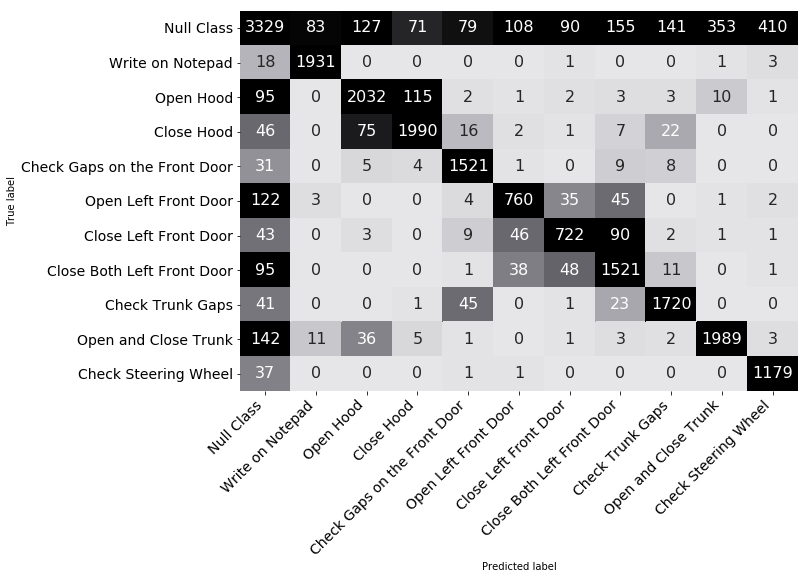

In [114]:
# Display beautifier confussion matrix

print_confusion_matrix(confusion_matrix, ['Null Class','Write on Notepad', 'Open Hood', 'Close Hood', 
                                          'Check Gaps on the Front Door', 'Open Left Front Door', 'Close Left Front Door',
                                          'Close Both Left Front Door', 'Check Trunk Gaps', 'Open and Close Trunk',
                                          'Check Steering Wheel'], vmax=85)

In [115]:
# Print validation metrices for trained model

print(metrics.classification_report(y, y_valid))

             precision    recall  f1-score   support

       32.0       0.83      0.67      0.74      4946
       48.0       0.95      0.99      0.97      1954
       49.0       0.89      0.90      0.89      2264
       50.0       0.91      0.92      0.92      2159
       51.0       0.91      0.96      0.93      1579
       52.0       0.79      0.78      0.79       972
       53.0       0.80      0.79      0.79       917
       54.0       0.82      0.89      0.85      1715
       55.0       0.90      0.94      0.92      1831
       56.0       0.84      0.91      0.87      2193
       57.0       0.74      0.97      0.84      1218

avg / total       0.86      0.86      0.86     21748



# Multi-Class Classification - Right Arm Only

In [69]:
# Form matrices to be used in training

X = np.array(dsR.iloc[:, 0:390])
y = np.array(dsR.iloc[:, 390])

In [101]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(195, input_dim=390, activation='relu',init='uniform'))
    model.add(Dense(95, activation='relu',init='uniform'))
    model.add(Dense(95, activation='relu',init='uniform'))
    model.add(Dense(95, activation='relu',init='uniform'))
    model.add(Dense(95, activation='relu',init='uniform'))
    model.add(Dense(195, activation='relu',init='uniform'))
    model.add(Dense(11,activation='sigmoid', init='uniform'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [102]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=200, verbose=1)

In [ ]:
y_valid = stratified_cv(X, y, estimator, normalize=True)

In [104]:
# Get prediction accuracy

accuracy = metrics.accuracy_score(y, y_valid)
print("Accuracy: ", accuracy)

Accuracy:  0.8461785927662117


In [105]:
# Display raw confussion matrix

confusion_matrix = metrics.confusion_matrix(y, y_valid)
print(confusion_matrix)

[[2916  166  150  190   50  474  205  168   90  320  387]
 [  31 1925    0    0    0    0    0    0    0    0    0]
 [  72    2 2039  108    2    1    0    0    2    0    0]
 [  60    1   70 1995    3    1    0    0    1    0    6]
 [  28    0    1    4 1499    0    0    5   13    1    0]
 [  78    3    1    1    1  795   94    0    0    1    0]
 [  64    0    1    2    2  128  719    0    0    0    0]
 [ 109    0    1    0    7    0    0 1547    3    1    0]
 [  30    0   14    4   15    0    0    5 1785    0    0]
 [ 109    0    0    0    2    0    0   10    1 2021    3]
 [  45    0    0    0    0    0    0    0    0    0 1171]]


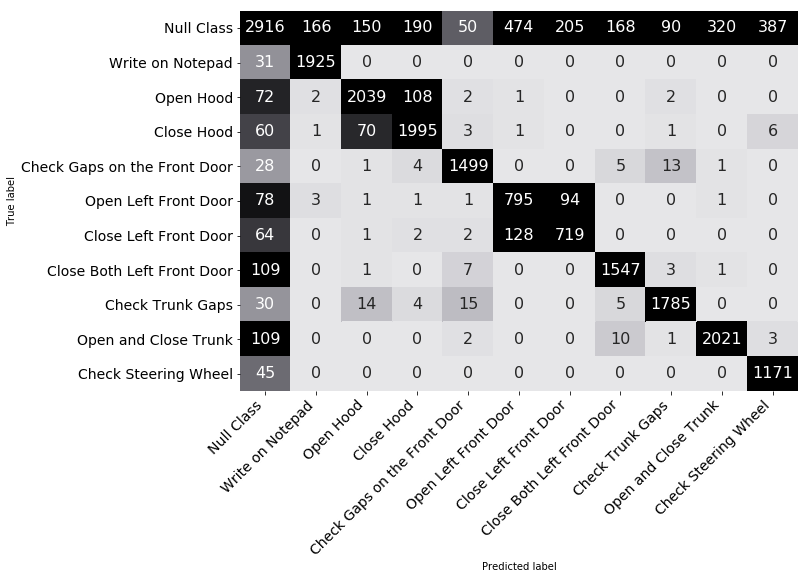

In [4]:
# Display beautifier confussion matrix

print_confusion_matrix(confusion_matrix, ['Null Class','Write on Notepad', 'Open Hood', 'Close Hood', 
                                          'Check Gaps on the Front Door', 'Open Left Front Door', 'Close Left Front Door',
                                          'Close Both Left Front Door', 'Check Trunk Gaps', 'Open and Close Trunk',
                                          'Check Steering Wheel'], vmax=85)

In [107]:
# Print validation metrices for trained model

print(metrics.classification_report(y, y_valid))

             precision    recall  f1-score   support

       32.0       0.82      0.57      0.67      5116
       48.0       0.92      0.98      0.95      1956
       49.0       0.90      0.92      0.91      2226
       50.0       0.87      0.93      0.90      2137
       51.0       0.95      0.97      0.96      1551
       52.0       0.57      0.82      0.67       974
       53.0       0.71      0.78      0.74       916
       54.0       0.89      0.93      0.91      1668
       55.0       0.94      0.96      0.95      1853
       56.0       0.86      0.94      0.90      2146
       57.0       0.75      0.96      0.84      1216

avg / total       0.85      0.85      0.84     21759



# Multi-Class Classification - Both Hands

In [118]:
# Form matrices to be used in training

X = np.array(dsB.iloc[:, 0:780])
y = np.array(dsB.iloc[:, 780])

In [119]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(390, input_dim=780, activation='relu',init='uniform'))
    model.add(Dense(195, activation='relu',init='uniform'))
    model.add(Dense(95, activation='relu',init='uniform'))
    model.add(Dense(95, activation='relu',init='uniform'))
    model.add(Dense(95, activation='relu',init='uniform'))
    model.add(Dense(390, activation='relu',init='uniform'))
    model.add(Dense(11,activation='sigmoid', init='uniform'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [120]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=200, verbose=1)

In [ ]:
y_valid = stratified_cv(X, y, estimator, normalize=True)

In [122]:
# Get prediction accuracy

accuracy = metrics.accuracy_score(y, y_valid)
print("Accuracy: ", accuracy)

Accuracy:  0.9139026441184714


In [123]:
# Display raw confussion matrix

confusion_matrix = metrics.confusion_matrix(y, y_valid)
print(confusion_matrix)

[[3608  106   70   36   22  296   87  148   74  116  308]
 [  13 1941    0    0    0    0    0    0    0    0    0]
 [  20    0 2106   71    0    0    0    0    0    1    0]
 [  17    0   64 2001    0    0    2    0    8    0    0]
 [  22    0    4    4 1490    0    0    4   18    0    0]
 [  37    0    0    0    0  896   36    3    0    0    0]
 [  23    1    0    0    0   24  867    0    0    1    0]
 [  25    0    1    1    0    2    3 1631    2    0    3]
 [  11    0    1    1   47    0    0    8 1763    0    0]
 [  41    0    6    6    0    1    0    1   17 2072    2]
 [  21    0    0    0    0    0    0    5    1    1 1188]]


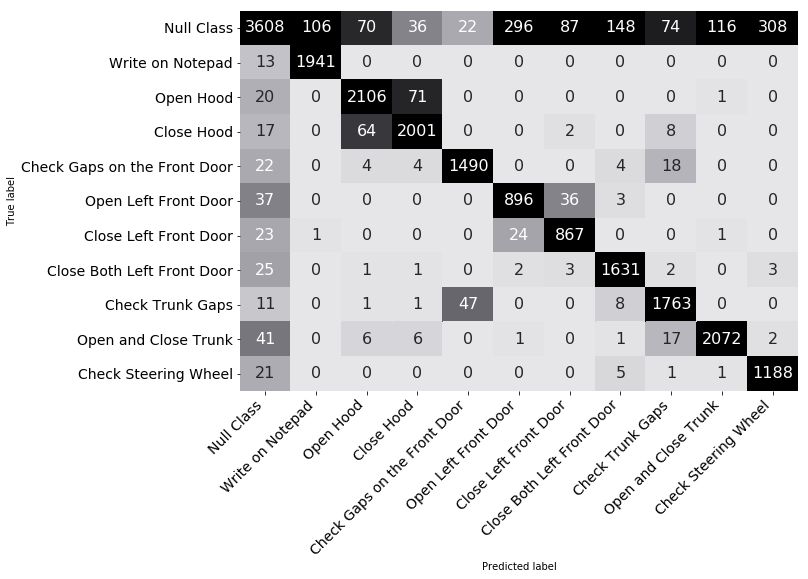

In [124]:
# Display beautifier confussion matrix

print_confusion_matrix(confusion_matrix, ['Null Class','Write on Notepad', 'Open Hood', 'Close Hood', 
                                          'Check Gaps on the Front Door', 'Open Left Front Door', 'Close Left Front Door',
                                          'Close Both Left Front Door', 'Check Trunk Gaps', 'Open and Close Trunk',
                                          'Check Steering Wheel'], vmax=85)

In [125]:
# Print validation metrices for trained model

print(metrics.classification_report(y, y_valid))

             precision    recall  f1-score   support

       32.0       0.94      0.74      0.83      4871
       48.0       0.95      0.99      0.97      1954
       49.0       0.94      0.96      0.95      2198
       50.0       0.94      0.96      0.95      2092
       51.0       0.96      0.97      0.96      1542
       52.0       0.74      0.92      0.82       972
       53.0       0.87      0.95      0.91       916
       54.0       0.91      0.98      0.94      1668
       55.0       0.94      0.96      0.95      1831
       56.0       0.95      0.97      0.96      2146
       57.0       0.79      0.98      0.87      1216

avg / total       0.92      0.91      0.91     21406

